In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import pprint
from pprint import pprint as pprint
import collections
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.schema import Table, DropTable
import pandas as pd

In [3]:
Session = sessionmaker()
engine = create_engine('sqlite:///twitter.db')

In [4]:
users = pd.read_sql_query('SELECT user1.user_name AS user, COUNT(*) as number_of_retweets, \
                            user2.user_name AS retwitter \
                            FROM user AS user1 \
                             JOIN tweet ON tweet.user_id = user1.user_id \
                             JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id \
                             JOIN user AS user2 ON retweet.user_id = user2.user_id \
                             GROUP BY user, retwitter', engine)
print(users[:10])

                                     user  number_of_retweets  \
0                                    None                   1   
1                       "We the People" 🏁                   1   
2  #Bangladesh News 24 (#BreakingNews 24)                   1   
3  #Bangladesh News 24 (#BreakingNews 24)                   1   
4                                #BearJew                   1   
5                      #BlueWave Thoughts                   1   
6                      #BlueWave Thoughts                   1   
7                      #BlueWave Thoughts                   1   
8                      #BlueWave Thoughts                   1   
9                      #BlueWave Thoughts                   1   

                            retwitter  
0                    #CANST/#GMNo🇺🇸🐸❌  
1                   marlene silva ⭐⭐⭐  
2      Save USA vote red ⭐️⭐️⭐️  🚂💨🇺🇸  
3                  The King Of Comedy  
4                    RestingWitchFace  
5                  #BlueWave Thoughts  
6   

In [5]:
G = nx.from_pandas_edgelist(users, 'user', 'retwitter', 'number_of_retweets')

In [6]:
# Get nodes with degree >= min_degree

min_degree = 100

nodes = [node for node, degree in G.degree() if degree >= min_degree]

In [7]:

# Create a subgraph with nodes degree >= min_degree (in the G graph)

G_sampled = G.subgraph(nodes)
pprint(nx.info(G_sampled))


('Name: \n'
 'Type: Graph\n'
 'Number of nodes: 168\n'
 'Number of edges: 706\n'
 'Average degree:   8.4048')


In [8]:
def get_histogram(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

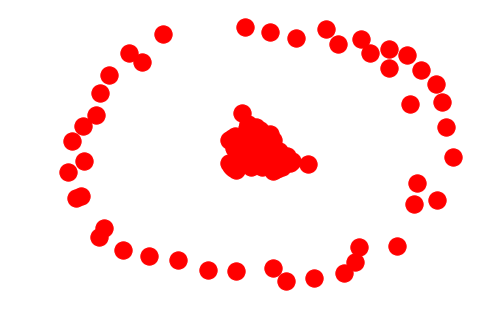

In [9]:
nx.draw(G_sampled, with_labels=False, edges=G_sampled.edges)
plt.show()

In [10]:
print("users", len(G_sampled.nodes))
print("connections",len(G_sampled.edges))

users 168
connections 706


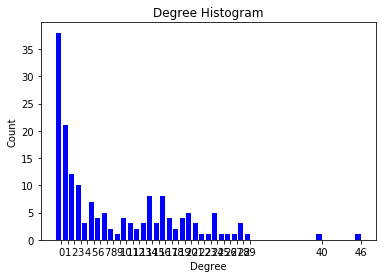

In [11]:
# avg_node_connectivity = nx.networkx.average_node_connectivity(G)
# print('Average node connectivity: ', avg_node_connectivity)

get_histogram(G_sampled)

In [14]:
from networkx.algorithms.community.centrality import girvan_newman
communities_iter = girvan_newman(G_sampled)

communities_sum = 0
communities_gn = []

for community_gn in next(communities_iter):
    communities_sum += 1
    communities_gn.append(community_gn)
    print("Community ", communities_sum)
    print(community_gn)
    print("Liczność community: ", len(community_gn), "\n")
    
print("Znaleziono communities: ", communities_sum)

Community  1
{'🇺🇸 Jason A. ❌', 'Liberty & Peace⭐️⭐️⭐️', 'BrooklynDad_Defiant!', '⏳Ethan Allen⏳', '🇺🇸California Condor🇺🇸', 'Donald J. Trump', 'GO RED STATE BY STATE', 'Ken Jones', 'John~💋Kiss My Bot', 'ＤａｒｋＧｒｅｙＧｈｏｓｔ🌹-K-', 'Alisande 🇺🇸', '🇺🇸 Jayne Q. Nationalist ⭐️⭐️⭐️', 'Heather Loesch', 'Girl♥️Bot', 'American Patriot', 'Marsha Blackburn', '🇺🇸The Responder🇺🇸', 'Advancing Justice | AAJC', 'pyrrhophytes ❌', 'The Columbia Bugle 🇺🇸', '❌ Daniel John Sobieski ❌', 'Տᗩᑎᗪᖇᗩ Vote Early GOP!!', 'Tim Donnelly for Congress', 'Cindyseestruth', 'ɳαɳ૮ყ ن💄#VOTERed', '🦅 🦅 Nationalist Eagle 🦅🦅', 'Adrian Norman', '⭐️⭐️⭐️ @gsPatton007  🥊BEAT DEMS NOV 6🇺🇸', 'Carrie 🇺🇸 Vote 🔴 Midterms', 'Charlotte Clymer🏳️\u200d🌈', 'DR. ETIQUETTE 🤦\u200d♂️', 'Ernie Plumley', 'TRUMPERLAND🇺🇸', 'Haley Kennington', 'Nationalist🇺🇸T🇺🇸', 'Steph', 'Sandpiper👑✝️✡️🐕🐈❤️', 'Cody', 'Sara', 'Nationalist Drew 🇺🇸🏁🍻', 'Dr. ❌ Deplorabelle ❌ Chicklet 🇺🇸🇺🇸', 'Black🕷Widow', 'Linda Suhler, PhD', 'Mike Tokes', '🇺🇸🔥Lady De’Plorable🔥🇺🇸', 'Christian C

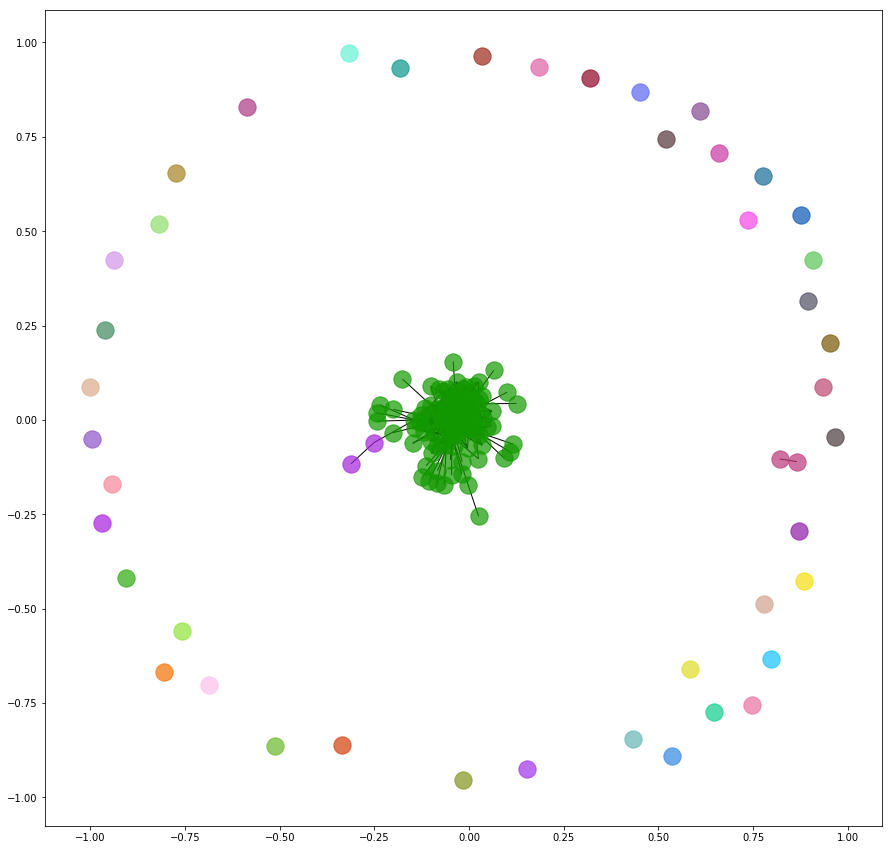

In [15]:
from matplotlib.pyplot import figure
import numpy

figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for community in list(communities_gn):
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=community,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_edges(G_sampled, pos=pos, edgelist=G_sampled.edges)

plt.show()

In [16]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
communities_gmc = greedy_modularity_communities(G_sampled)

communities_sum = 0

for community_gmc in communities_gmc:
    communities_sum += 1
    print("Community ", communities_sum)
    print(community_gmc)
    print("Liczność community: ", len(community_gmc), "\n")
    
print("Znaleziono communities: ", communities_sum)

Community  1
frozenset({'(((DeanObeidallah)))', 'Bill Mitchell', 'Mike', 'Dr. Marty Fox', 'Sara', 'Nationalist Drew 🇺🇸🏁🍻', 'Julian Svendsen', 'Donald J. Trump', 'Mike Tokes', 'Girl♥️Bot', 'ℂ𝕙𝕣𝕚𝕤𝕥𝕚𝕟𝕖💋', 'Cali-Conservative🇺🇸', 'Fox News Research', '🇺🇸 Miguelifornia', '🇺🇸The Responder🇺🇸', 'Mark "Beto" Pantano', '#ThePersistence', 'The Columbia Bugle 🇺🇸', 'Barb🏇ÓRothláin', 'Kat  #ISTANDWITHGENFLYNN', 'Loomered❤️Molly⭐️⭐️⭐️', '🇺🇸 SKY45 🇺🇸 ︻デ═一', 'Տᗩᑎᗪᖇᗩ Vote Early GOP!!', 'GRIZZ 🍺', 'NTK Network', 'ɳαɳ૮ყ ن💄#VOTERed', 'Jill 🇺🇸', 'Deplorable Dan 🇺🇸', 'HISTORY', 'JRehling', 'DrLee MD is A NATIONALIST', 'Carrie 🇺🇸 Vote 🔴 Midterms', 'DR. ETIQUETTE 🤦\u200d♂️', 'TRUMPERLAND🇺🇸'})
Liczność community:  34 

Community  2
frozenset({'SeaneyB ♦️ ⭐⭐⭐', '🇺🇸 Jason A. ❌', 'Liberty & Peace⭐️⭐️⭐️', '⏳Ethan Allen⏳', 'Joanne 👑👠💄👑🌺🌹#wife#mother#grandmother', '🌟Patriotic Cindy🌟🚂🔴🐘🐘🇺🇸🇨🇱', 'Dorcas↩', 'Ken Jones', 'GO RED STATE BY STATE', 'Alisande 🇺🇸', 'Heather Loesch', '🇺🇸🔥Lady De’Plorable🔥🇺🇸', 'Chris  🇺🇸 Let Free

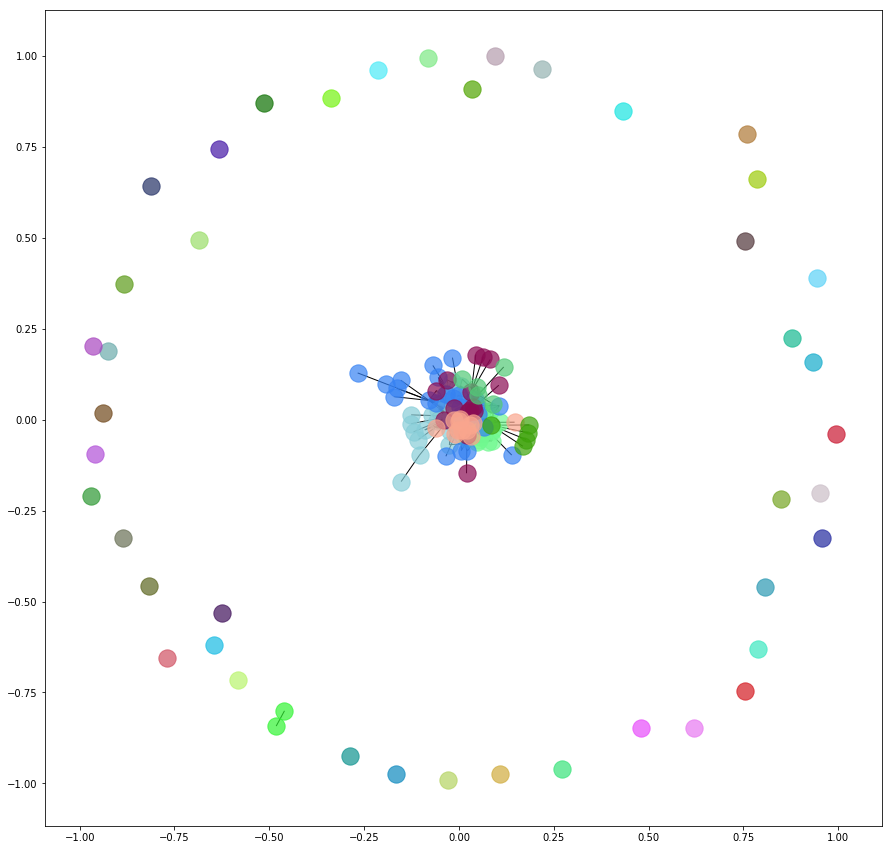

In [17]:
figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for community in communities_gmc:
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=community,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_edges(G_sampled, pos=pos, edgelist=G_sampled.edges)

plt.show()

In [18]:
sorted(G_sampled.degree, key=lambda x: x[1], reverse=True)[:10]


[('Mike', 46),
 ('Patriot Gary', 40),
 ('Cindyseestruth', 29),
 ('@gary[WontBackDown]', 28),
 ('Kat  #ISTANDWITHGENFLYNN', 28),
 ('Sektor (K)', 28),
 ('GRIZZ 🍺', 27),
 ('Black🕷Widow', 26),
 ('🇺🇸🔥Lady De’Plorable🔥🇺🇸', 25),
 ('Ken Jones', 24)]

In [105]:
degree_centrality = sorted(nx.degree_centrality(G_sampled).items(), key=lambda x: x[1], reverse=True)

In [106]:
degree_centrality[:10]

[('Mike', 0.2754491017964072),
 ('Patriot Gary', 0.23952095808383234),
 ('Cindyseestruth', 0.17365269461077845),
 ('@gary[WontBackDown]', 0.16766467065868265),
 ('Kat  #ISTANDWITHGENFLYNN', 0.16766467065868265),
 ('Sektor (K)', 0.16766467065868265),
 ('GRIZZ 🍺', 0.16167664670658682),
 ('Black🕷Widow', 0.15568862275449102),
 ('🇺🇸🔥Lady De’Plorable🔥🇺🇸', 0.14970059880239522),
 ('Ken Jones', 0.14371257485029942)]

In [107]:
betweenness_centrality = sorted(nx.betweenness_centrality(G_sampled).items(), key=lambda x: x[1], reverse=True)

In [108]:
betweenness_centrality[:10]

[('Mike', 0.10839565564185784),
 ('CC', 0.04622116482907205),
 ('Patriot Gary', 0.04387773712096987),
 ('Elaine', 0.03608102655887565),
 ('Save USA vote red ⭐️⭐️⭐️  🚂💨🇺🇸', 0.03089815483015682),
 ('TheKat ❤️', 0.029337574183152203),
 ('Ken Jones', 0.026113052789717903),
 ('Laura Vote Red', 0.025180747223808152),
 ('Cindyseestruth', 0.024175479983598203),
 ('Cody', 0.019253775810283102)]

In [109]:
edge_betweenness_centrality = sorted(nx.edge_betweenness_centrality(G_sampled).items(), key=lambda x: x[1], reverse=True)

In [110]:
edge_betweenness_centrality[:10]

[(('CC', 'Kaz Weida'), 0.017251211861990308),
 (('Fox News Research', 'Mike'), 0.017251211861990308),
 (('Patriot Gary', 'CC'), 0.012460941878600081),
 (('Ken Jones', 'CC'), 0.010613874933753637),
 (('Elaine', 'Mike'), 0.010280474317392025),
 (('CC', 'TheKat ❤️'), 0.008947381282735142),
 (('🇺🇸California Condor🇺🇸', 'Jackie'), 0.008696891930424866),
 (('Donald J. Trump', 'Fox News Research'), 0.008696891930424866),
 (('John~💋Kiss My Bot', 'Patriot Gary'), 0.008696891930424866),
 (('🇺🇸 Jayne Q. Nationalist ⭐️⭐️⭐️', 'Dr. Lynn J Anderson'),
  0.008696891930424866)]

In [84]:
from networkx.algorithms.community import k_clique_communities
cliques = list(k_clique_communities(G_sampled, 6))

In [85]:
for clique in cliques:
    print(len(clique))
    print(clique)

6
frozenset({'RW 😡', '⭐️⭐️⭐️ @gsPatton007  🥊BEAT DEMS NOV 6🇺🇸', 'Patriot Gary', '⏳Ethan Allen⏳', '🇺🇸Nationalist Lori🇺🇸 #WWG1WGA', 'ＤａｒｋＧｒｅｙＧｈｏｓｔ🌹-K-'})
7
frozenset({'Sektor (K)', 'Nationalist🇺🇸T🇺🇸', '🇺🇸🔥Lady De’Plorable🔥🇺🇸', 'ღReflectionsofJMღ ♨️ᶜᵒᶰˢᵉʳᵛᵃᵗᶦᵛᵉ', 'Patriot Gary', 'Chris  🇺🇸 Let Freedom Ring', '@gary[WontBackDown]'})
6
frozenset({'RW 😡', 'Nationalist🇺🇸T🇺🇸', 'Patriot Gary', 'Matthew', 'Chris  🇺🇸 Let Freedom Ring', '@gary[WontBackDown]'})
21
frozenset({'Mike', 'Arch Kennedy', 'Kat  #ISTANDWITHGENFLYNN', '🐘🇺🇸 Kim 🇺🇸🐘', 'Patriot Gary', 'GRIZZ 🍺', 'Cody', 'Sektor (K)', '🌟Patriotic Cindy🌟🚂🔴🐘🐘🇺🇸🇨🇱', 'Robin 🇺🇸❤️🇺🇸', 'Dorcas↩', 'Nationalist Drew 🇺🇸🏁🍻', 'Anna❤Trump Nationalist🇺🇸🇮🇹', 'Deplorable Dan 🇺🇸', 'Black🕷Widow', '🇺🇸🔥Lady De’Plorable🔥🇺🇸', 'Girl♥️Bot', 'Carrie 🇺🇸 Vote 🔴 Midterms', 'ღReflectionsofJMღ ♨️ᶜᵒᶰˢᵉʳᵛᵃᵗᶦᵛᵉ', '🇺🇸 Miguelifornia', 'Chris  🇺🇸 Let Freedom Ring'})
6
frozenset({'Arch Kennedy', 'Kat  #ISTANDWITHGENFLYNN', '🐘🇺🇸 Kim 🇺🇸🐘', '🇺🇸🔥Lady De’Plorable🔥🇺🇸', 'TheKat ❤️', 'Jen

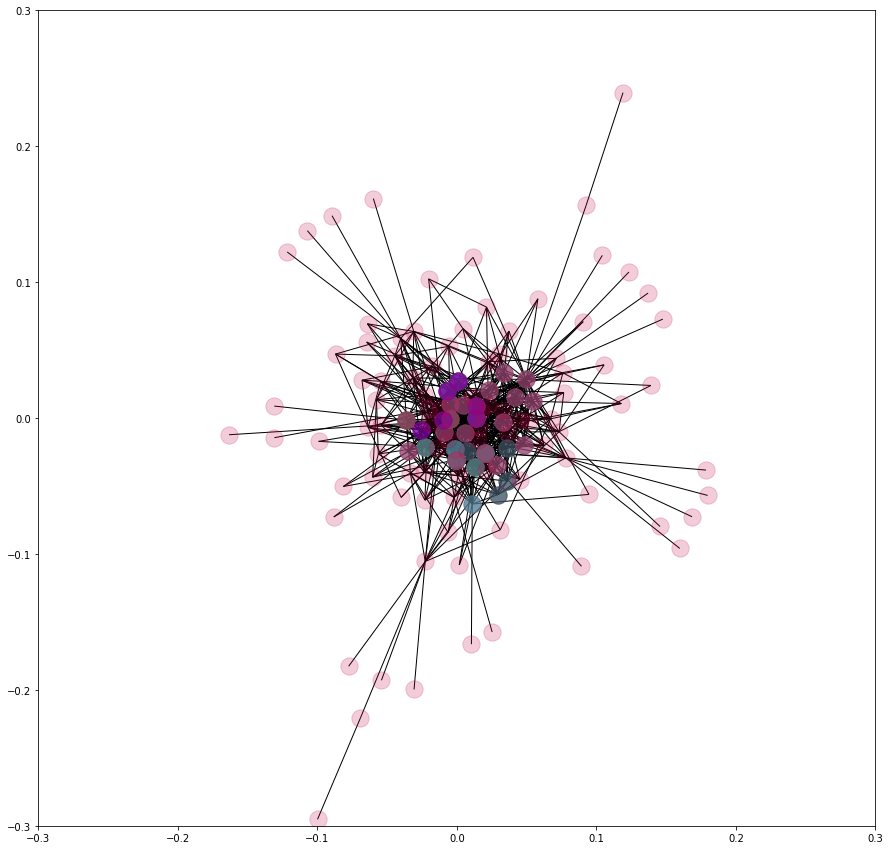

In [87]:
figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for clique in cliques:
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=clique,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=G_sampled.nodes,
                           node_color=numpy.random.rand(3,),
                           alpha=0.2)
nx.draw_networkx_edges(G_sampled, pos=pos, edgelist=G_sampled.edges)

plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)

plt.show()

In [103]:
# active users in distinct cliques

distinct_users_in_cliques = {}

for clique in cliques:
    for user in clique:
        if user in distinct_users_in_cliques:
            distinct_users_in_cliques[user] += 1
        else:
            distinct_users_in_cliques[user] = 1

In [104]:
top_users_in_cliques = sorted(distinct_users_in_cliques.items(), key=lambda x : x[1], reverse=True)
top_users_in_cliques[:5]

[('Patriot Gary', 4),
 ('🇺🇸🔥Lady De’Plorable🔥🇺🇸', 3),
 ('Chris  🇺🇸 Let Freedom Ring', 3),
 ('RW 😡', 2),
 ('Sektor (K)', 2)]